In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
#%matplotlib notebook
#import matplotlib.pylab as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd
import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()
if num_cores == 32:
    num_cores = 24  # lsst-dev - don't use all the cores, man.
elif num_cores == 8:
    num_cores = 3
elif num_cores == 4:
    num_cores = 2
print num_cores

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

pd.options.display.max_columns = 9999
pd.set_option('display.width', 9999)

import warnings
warnings.filterwarnings('ignore')

import diffimTests as dit

3


In [2]:
# Set up console so we can reattach via terminal ipython later. See:
# https://stackoverflow.com/questions/19479645/using-ipython-console-along-side-ipython-notebook

%qtconsole

# Then do `ipython console --existing` in a terminal to connect and have access to same data!
# But note, do not do CTRL-D in that terminal or it will kill the kernel!

Here I re-wrote `runTest` to use `afwTable.matchXy()` for catalog matching (instead of my own matching).
The resulting numbers are slightly different. The old values were:
    
```
{'ZOGY': {'FP': 4, 'FN': 24, 'TP': 26}, 'ALstack': {'FP': 2, 'FN': 25, 'TP': 25}, 'SZOGY': {'FP': 4, 'FN': 24, 'TP': 26}, 'ALstack_decorr': {'FP': 5, 'FN': 25, 'TP': 25}}
```

In [3]:
reload(dit)
testObj = dit.DiffimTest(n_sources=500, sourceFluxRange=(2000, 20000), 
                         varFlux2=np.linspace(200, 2000, 50),
                         #varFlux2=np.repeat(500., 50),
                         templateNoNoise=True, skyLimited=True,
                        avoidAllOverlaps=15.)
res = testObj.runTest(returnSources=True, matchDist=np.sqrt(1.5))
src = res['sources']
del res['sources']
print res

{'ZOGY': {'FP': 3, 'FN': 11, 'TP': 39}, 'ALstack': {'FP': 1, 'FN': 12, 'TP': 38}, 'SZOGY': {'FP': 1, 'FN': 10, 'TP': 40}, 'ALstack_decorr': {'FP': 1, 'FN': 12, 'TP': 38}}


Do forced phot. now with funcs in diffimTests:

In [4]:
cats = testObj.doForcedPhot(transientsOnly=True)
sources, fp1, fp2, fp_ZOGY, fp_AL, fp_ALd = cats

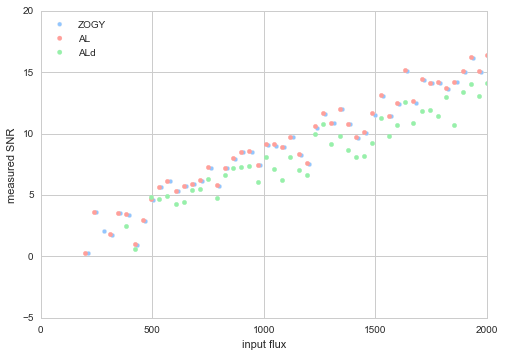

In [5]:
#%matplotlib notebook
plt.scatter(sources['inputFlux_science']+10, fp_ZOGY['base_PsfFlux_flux']/fp_ZOGY['base_PsfFlux_fluxSigma'], label='ZOGY')
plt.scatter(sources['inputFlux_science'], fp_AL['base_PsfFlux_flux']/fp_AL['base_PsfFlux_fluxSigma'], label='AL', color='r')
plt.scatter(sources['inputFlux_science'], fp_ALd['base_PsfFlux_flux']/fp_ALd['base_PsfFlux_fluxSigma'], label='ALd', color='g')
plt.legend(loc='upper left')
plt.xlabel('input flux')
plt.ylabel('measured SNR')
plt.xlim(0, 2000);

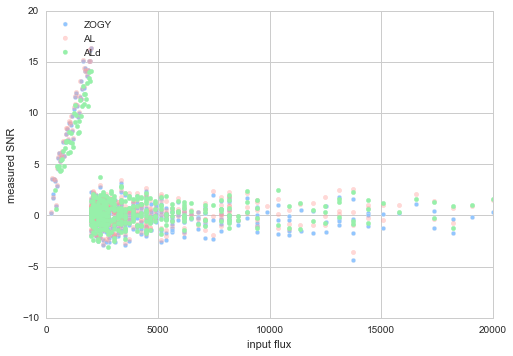

In [6]:
cats = testObj.doForcedPhot(transientsOnly=False)
sources, fp1, fp2, fp_ZOGY, fp_AL, fp_ALd = cats
#%matplotlib notebook
plt.scatter(sources['inputFlux_science']+10, fp_ZOGY['base_PsfFlux_flux']/fp_ZOGY['base_PsfFlux_fluxSigma'], label='ZOGY')
plt.scatter(sources['inputFlux_science'], fp_AL['base_PsfFlux_flux']/fp_AL['base_PsfFlux_fluxSigma'], label='AL', color='r', alpha=0.4)
plt.scatter(sources['inputFlux_science'], fp_ALd['base_PsfFlux_flux']/fp_ALd['base_PsfFlux_fluxSigma'], label='ALd', color='g')
plt.legend(loc='upper left')
plt.xlabel('input flux')
plt.ylabel('measured SNR')
plt.xlim(0, 20000);

Try to compute SNR directly using (a) source flux, (b) background variance, and (c) PSF...

In [7]:
flux = 750.
psf = testObj.im2.psf
sky = testObj.im2.sig**2
print sky

nPix = np.sum(psf/psf.max()) * 2.  # not sure where the 2 comes from but it works.
print nPix, np.pi*1.8*2.2*4  # and it equals pi*r1*r2*4.

def snr(flux, sky, psf, skyLimited=True):
    psf = psf / psf.max()
    nPix = np.sum(psf) * 2.
    if skyLimited:  #  only sky noise matters 
        return flux / (np.sqrt(nPix * sky))
    else:
        return flux / (np.sqrt(flux + nPix * sky))

print snr(flux, sky, psf)
print testObj.im2.calcSNR(flux, skyLimited=True)  # moved the func here.

299.95665566
49.7628276329 49.7628276329
6.13874349599
6.13874349599


0.997874609125


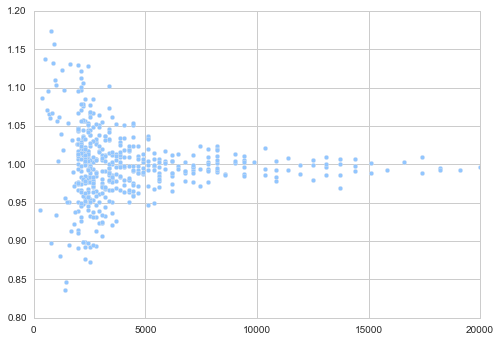

In [8]:
meas = fp2['base_PsfFlux_flux']/fp2['base_PsfFlux_fluxSigma']
calc = testObj.im2.calcSNR(sources['inputFlux_science'], skyLimited=True)
print np.median(meas/calc)
plt.scatter(sources['inputFlux_science'], meas/calc)
plt.xlim(0, 20000)
plt.ylim(0.8, 1.2);

Figure out matching. Match sources detected in ZOGY diffim to input transients.

In [9]:
cats = testObj.doForcedPhot(transientsOnly=True)
sources, fp1, fp2, fp_ZOGY, fp_AL, fp_ALd = cats
dit.sizeme(dit.catalogToDF(sources).head())

,centroid_x,centroid_y,coord_dec,coord_ra,id,inputFlux_science,inputFlux_template,parent
0,197.457149,414.015301,0.927951,3.761644,1,1191.836735,0.0,0
1,152.201064,152.325854,0.928185,3.761575,2,1412.244898,0.0,0
2,439.876934,358.486998,0.927997,3.762004,3,567.346939,0.0,0
3,371.625483,217.622330,0.928124,3.761901,4,1595.918367,0.0,0
4,343.639653,133.832701,0.928199,3.761859,5,1338.775510,0.0,0


Cross-reference the *detections* in ZOGY (`src['ZOGY']`) with the input sources `sources` to identify which of the 50 input transients were detected.

In [10]:
import lsst.afw.table as afwTable
import lsst.afw.table.catalogMatches as catMatch
import lsst.daf.base as dafBase
reload(dit)

matches = afwTable.matchXy(sources, src['ZOGY'], 1.0)
print len(matches)

metadata = dafBase.PropertyList()
matchCat = catMatch.matchesToCatalog(matches, metadata)
tmp = dit.catalogToDF(matchCat)
dit.sizeme(tmp.head())

39


,distance,ref_centroid_x,ref_centroid_y,ref_coord_dec,ref_coord_ra,ref_id,ref_inputFlux_science,ref_inputFlux_template,ref_parent,src_base_CircularApertureFlux_12_0_flag,src_base_CircularApertureFlux_12_0_flag_apertureTruncated,src_base_CircularApertureFlux_12_0_flux,src_base_CircularApertureFlux_12_0_fluxSigma,src_base_CircularApertureFlux_17_0_flag,src_base_CircularApertureFlux_17_0_flag_apertureTruncated,src_base_CircularApertureFlux_17_0_flux,src_base_CircularApertureFlux_17_0_fluxSigma,src_base_CircularApertureFlux_25_0_flag,src_base_CircularApertureFlux_25_0_flag_apertureTruncated,src_base_CircularApertureFlux_25_0_flux,src_base_CircularApertureFlux_25_0_fluxSigma,src_base_CircularApertureFlux_35_0_flag,src_base_CircularApertureFlux_35_0_flag_apertureTruncated,src_base_CircularApertureFlux_35_0_flux,src_base_CircularApertureFlux_35_0_fluxSigma,src_base_CircularApertureFlux_3_0_flag,src_base_CircularApertureFlux_3_0_flag_apertureTruncated,src_base_CircularApertureFlux_3_0_flag_sincCoeffsTruncated,src_base_CircularApertureFlux_3_0_flux,src_base_CircularApertureFlux_3_0_fluxSigma,src_base_CircularApertureFlux_4_5_flag,src_base_CircularApertureFlux_4_5_flag_apertureTruncated,src_base_CircularApertureFlux_4_5_flag_sincCoeffsTruncated,src_base_CircularApertureFlux_4_5_flux,src_base_CircularApertureFlux_4_5_fluxSigma,src_base_CircularApertureFlux_50_0_flag,src_base_CircularApertureFlux_50_0_flag_apertureTruncated,src_base_CircularApertureFlux_50_0_flux,src_base_CircularApertureFlux_50_0_fluxSigma,src_base_CircularApertureFlux_6_0_flag,src_base_CircularApertureFlux_6_0_flag_apertureTruncated,src_base_CircularApertureFlux_6_0_flag_sincCoeffsTruncated,src_base_CircularApertureFlux_6_0_flux,src_base_CircularApertureFlux_6_0_fluxSigma,src_base_CircularApertureFlux_70_0_flag,src_base_CircularApertureFlux_70_0_flag_apertureTruncated,src_base_CircularApertureFlux_70_0_flux,src_base_CircularApertureFlux_70_0_fluxSigma,src_base_CircularApertureFlux_9_0_flag,src_base_CircularApertureFlux_9_0_flag_apertureTruncated,src_base_CircularApertureFlux_9_0_flag_sincCoeffsTruncated,src_base_CircularApertureFlux_9_0_flux,src_base_CircularApertureFlux_9_0_fluxSigma,src_base_GaussianCentroid_flag,src_base_GaussianCentroid_flag_noPeak,src_base_GaussianCentroid_flag_resetToPeak,src_base_GaussianCentroid_x,src_base_GaussianCentroid_y,src_base_GaussianFlux_flag,src_base_GaussianFlux_flux,src_base_GaussianFlux_fluxSigma,src_base_NaiveCentroid_flag,src_base_NaiveCentroid_flag_edge,src_base_NaiveCentroid_flag_noCounts,src_base_NaiveCentroid_flag_resetToPeak,src_base_NaiveCentroid_x,src_base_NaiveCentroid_y,src_base_PeakCentroid_flag,src_base_PeakCentroid_x,src_base_PeakCentroid_y,src_base_PeakLikelihoodFlux_flag,src_base_PeakLikelihoodFlux_flux,src_base_PeakLikelihoodFlux_fluxSigma,src_base_PixelFlags_flag,src_base_PixelFlags_flag_bad,src_base_PixelFlags_flag_cr,src_base_PixelFlags_flag_crCenter,src_base_PixelFlags_flag_edge,src_base_PixelFlags_flag_interpolated,src_base_PixelFlags_flag_interpolatedCenter,src_base_PixelFlags_flag_offimage,src_base_PixelFlags_flag_saturated,src_base_PixelFlags_flag_saturatedCenter,src_base_PixelFlags_flag_suspect,src_base_PixelFlags_flag_suspectCenter,src_base_PsfFlux_flag,src_base_PsfFlux_flag_edge,src_base_PsfFlux_flag_noGoodPixels,src_base_PsfFlux_flux,src_base_PsfFlux_fluxSigma,src_base_SdssCentroid_flag,src_base_SdssCentroid_flag_almostNoSecondDerivative,src_base_SdssCentroid_flag_edge,src_base_SdssCentroid_flag_noSecondDerivative,src_base_SdssCentroid_flag_notAtMaximum,src_base_SdssCentroid_flag_resetToPeak,src_base_SdssCentroid_x,src_base_SdssCentroid_xSigma,src_base_SdssCentroid_y,src_base_SdssCentroid_ySigma,src_base_SdssShape_flag,src_base_SdssShape_flag_maxIter,src_base_SdssShape_flag_psf,src_base_SdssShape_flag_shift,src_base_SdssShape_flag_unweighted,src_base_SdssShape_flag_unweightedBad,src_base_SdssShape_flux,src_base_SdssShape_fluxSigma,src_base_SdssShape_flux_xx_Cov,src_base_SdssShape_flux_xy_Cov,src_base_Sds

OK, we can cross-ref the `ref_id` of `matchesCat` with `id` of `sources`.

In [11]:
dit.sizeme(tmp[np.in1d(tmp['ref_id'], [1,2,3,4,5])])

,distance,ref_centroid_x,ref_centroid_y,ref_coord_dec,ref_coord_ra,ref_id,ref_inputFlux_science,ref_inputFlux_template,ref_parent,src_base_CircularApertureFlux_12_0_flag,src_base_CircularApertureFlux_12_0_flag_apertureTruncated,src_base_CircularApertureFlux_12_0_flux,src_base_CircularApertureFlux_12_0_fluxSigma,src_base_CircularApertureFlux_17_0_flag,src_base_CircularApertureFlux_17_0_flag_apertureTruncated,src_base_CircularApertureFlux_17_0_flux,src_base_CircularApertureFlux_17_0_fluxSigma,src_base_CircularApertureFlux_25_0_flag,src_base_CircularApertureFlux_25_0_flag_apertureTruncated,src_base_CircularApertureFlux_25_0_flux,src_base_CircularApertureFlux_25_0_fluxSigma,src_base_CircularApertureFlux_35_0_flag,src_base_CircularApertureFlux_35_0_flag_apertureTruncated,src_base_CircularApertureFlux_35_0_flux,src_base_CircularApertureFlux_35_0_fluxSigma,src_base_CircularApertureFlux_3_0_flag,src_base_CircularApertureFlux_3_0_flag_apertureTruncated,src_base_CircularApertureFlux_3_0_flag_sincCoeffsTruncated,src_base_CircularApertureFlux_3_0_flux,src_base_CircularApertureFlux_3_0_fluxSigma,src_base_CircularApertureFlux_4_5_flag,src_base_CircularApertureFlux_4_5_flag_apertureTruncated,src_base_CircularApertureFlux_4_5_flag_sincCoeffsTruncated,src_base_CircularApertureFlux_4_5_flux,src_base_CircularApertureFlux_4_5_fluxSigma,src_base_CircularApertureFlux_50_0_flag,src_base_CircularApertureFlux_50_0_flag_apertureTruncated,src_base_CircularApertureFlux_50_0_flux,src_base_CircularApertureFlux_50_0_fluxSigma,src_base_CircularApertureFlux_6_0_flag,src_base_CircularApertureFlux_6_0_flag_apertureTruncated,src_base_CircularApertureFlux_6_0_flag_sincCoeffsTruncated,src_base_CircularApertureFlux_6_0_flux,src_base_CircularApertureFlux_6_0_fluxSigma,src_base_CircularApertureFlux_70_0_flag,src_base_CircularApertureFlux_70_0_flag_apertureTruncated,src_base_CircularApertureFlux_70_0_flux,src_base_CircularApertureFlux_70_0_fluxSigma,src_base_CircularApertureFlux_9_0_flag,src_base_CircularApertureFlux_9_0_flag_apertureTruncated,src_base_CircularApertureFlux_9_0_flag_sincCoeffsTruncated,src_base_CircularApertureFlux_9_0_flux,src_base_CircularApertureFlux_9_0_fluxSigma,src_base_GaussianCentroid_flag,src_base_GaussianCentroid_flag_noPeak,src_base_GaussianCentroid_flag_resetToPeak,src_base_GaussianCentroid_x,src_base_GaussianCentroid_y,src_base_GaussianFlux_flag,src_base_GaussianFlux_flux,src_base_GaussianFlux_fluxSigma,src_base_NaiveCentroid_flag,src_base_NaiveCentroid_flag_edge,src_base_NaiveCentroid_flag_noCounts,src_base_NaiveCentroid_flag_resetToPeak,src_base_NaiveCentroid_x,src_base_NaiveCentroid_y,src_base_PeakCentroid_flag,src_base_PeakCentroid_x,src_base_PeakCentroid_y,src_base_PeakLikelihoodFlux_flag,src_base_PeakLikelihoodFlux_flux,src_base_PeakLikelihoodFlux_fluxSigma,src_base_PixelFlags_flag,src_base_PixelFlags_flag_bad,src_base_PixelFlags_flag_cr,src_base_PixelFlags_flag_crCenter,src_base_PixelFlags_flag_edge,src_base_PixelFlags_flag_interpolated,src_base_PixelFlags_flag_interpolatedCenter,src_base_PixelFlags_flag_offimage,src_base_PixelFlags_flag_saturated,src_base_PixelFlags_flag_saturatedCenter,src_base_PixelFlags_flag_suspect,src_base_PixelFlags_flag_suspectCenter,src_base_PsfFlux_flag,src_base_PsfFlux_flag_edge,src_base_PsfFlux_flag_noGoodPixels,src_base_PsfFlux_flux,src_base_PsfFlux_fluxSigma,src_base_SdssCentroid_flag,src_base_SdssCentroid_flag_almostNoSecondDerivative,src_base_SdssCentroid_flag_edge,src_base_SdssCentroid_flag_noSecondDerivative,src_base_SdssCentroid_flag_notAtMaximum,src_base_SdssCentroid_flag_resetToPeak,src_base_SdssCentroid_x,src_base_SdssCentroid_xSigma,src_base_SdssCentroid_y,src_base_SdssCentroid_ySigma,src_base_SdssShape_flag,src_base_SdssShape_flag_maxIter,src_base_SdssShape_flag_psf,src_base_SdssShape_flag_shift,src_base_SdssShape_flag_unweighted,src_base_SdssShape_flag_unweightedBad,src_base_SdssShape_flux,src_base_SdssShape_fluxSigma,src_base_SdssShape_flux_xx_Cov,src_base_SdssShape_flux_xy_Cov,src_base_Sds

In [12]:
def plotWithDetectionsHighlighted(testObj, transientsOnly=True, addPresub=False, 
                                  xaxisIsScienceForcedPhot=False, alpha=0.5):
    
    #fp_DIFFIM=fp_ZOGY, label='ZOGY', color='b', alpha=1.0,
    
    res = testObj.runTest(returnSources=True, matchDist=np.sqrt(1.5))
    src = res['sources']
    del res['sources']
    print res
    
    cats = testObj.doForcedPhot(transientsOnly=transientsOnly)
    sources, fp1, fp2, fp_ZOGY, fp_AL, fp_ALd = cats

    # if xaxisIsScienceForcedPhot is True, then don't use sources['inputFlux_science'] --
    #    use fp2['base_PsfFlux_flux'] instead.
    if not xaxisIsScienceForcedPhot:
        srces = sources['inputFlux_science']
    else:
        srces = fp2['base_PsfFlux_flux']
        
    df = pd.DataFrame()
    df['inputFlux'] = sources['inputFlux_science']
    df['templateFlux'] = fp1['base_PsfFlux_flux']
    df['scienceFlux'] = fp2['base_PsfFlux_flux']
    df['inputId'] = sources['id']
    df['inputCentroid_x'] = sources['centroid_x']
    df['inputCentroid_y'] = sources['centroid_y']
    
    fp_DIFFIM = [fp_ZOGY, fp_AL, fp_ALd]
    label = ['ZOGY', 'ALstack', 'ALstack_decorr']
    color = ['b', 'r', 'g']
    
    for i, fp_d in enumerate(fp_DIFFIM):
        df[label[i] + '_SNR'] = fp_d['base_PsfFlux_flux']/fp_d['base_PsfFlux_fluxSigma']

        plt.scatter(srces, 
                    fp_d['base_PsfFlux_flux']/fp_d['base_PsfFlux_fluxSigma'], 
                    color=color[i], alpha=alpha, label=None, s=10)
        plt.scatter(srces, 
                    fp_d['base_PsfFlux_flux']/fp_d['base_PsfFlux_fluxSigma'], 
                    color='k', marker='x', alpha=alpha, label=None, s=10)

        if not xaxisIsScienceForcedPhot:
            matches = afwTable.matchXy(sources, src[label[i]], 1.0)
            metadata = dafBase.PropertyList()
            matchCat = catMatch.matchesToCatalog(matches, metadata)
            sources_detected = dit.catalogToDF(sources)
            detected = np.in1d(sources_detected['id'], matchCat['ref_id'])
            sources_detected = sources_detected[detected]
            sources_detected = sources_detected['inputFlux_science']
            fp_ZOGY_detected = dit.catalogToDF(fp_d)
            detected = np.in1d(fp_ZOGY_detected['id'], matchCat['ref_id'])
            fp_ZOGY_detected = fp_ZOGY_detected[detected]
        else:
            matches = afwTable.matchXy(fp2, src[label[i]], 1.0)
            metadata = dafBase.PropertyList()
            matchCat = catMatch.matchesToCatalog(matches, metadata)
            sources_detected = dit.catalogToDF(fp2)
            detected = np.in1d(sources_detected['id'], matchCat['ref_id'])
            sources_detected = sources_detected[detected]
            sources_detected = sources_detected['base_PsfFlux_flux']
            fp_ZOGY_detected = dit.catalogToDF(fp_d)
            detected = np.in1d(fp_ZOGY_detected['id'], matchCat['ref_id'])
            fp_ZOGY_detected = fp_ZOGY_detected[detected]

        df[label[i] + '_detected'] = detected
        plt.scatter(sources_detected, 
                    fp_ZOGY_detected['base_PsfFlux_flux']/fp_ZOGY_detected['base_PsfFlux_fluxSigma'], 
                    label=label[i], s=20, color=color[i], alpha=alpha) #, edgecolors='r')
    
    if addPresub: # Add measurements in original science and template images
        df['templateSNR'] = fp1['base_PsfFlux_flux']/fp1['base_PsfFlux_fluxSigma']
        plt.scatter(srces, 
                    fp1['base_PsfFlux_flux']/fp1['base_PsfFlux_fluxSigma'], 
                    label='template', color='y', alpha=alpha)
        df['scienceSNR'] = fp2['base_PsfFlux_flux']/fp2['base_PsfFlux_fluxSigma']
        plt.scatter(srces, 
                    fp2['base_PsfFlux_flux']/fp2['base_PsfFlux_fluxSigma'], 
                    label='science', color='orange', alpha=alpha-0.2)
        
    snrCalced = testObj.im2.calcSNR(sources['inputFlux_science'], skyLimited=True)
    df['inputSNR'] = snrCalced
    plt.scatter(srces, snrCalced, color='k', alpha=alpha-0.2, s=7, label='Input SNR')
    plt.scatter([10000], [10], color='k', marker='x', label='Missed')
    plt.legend(loc='upper left', scatterpoints=3)
    if not xaxisIsScienceForcedPhot:
        plt.xlabel('input flux')
    else:
        plt.xlabel('science flux (measured)')
    plt.ylabel('measured SNR')

    return df

Re-do with new `avoidAllOverlaps` option set to an avoidance radius of 5.

In [13]:
## Just re-create the testObj here:
reload(dit)
testObj = dit.DiffimTest(n_sources=500, sourceFluxRange=(2000, 20000), 
                         varFlux2=np.linspace(200, 2000, 50),
                         #varFlux2=np.repeat(500., 50),
                         templateNoNoise=True, skyLimited=True,
                         avoidAllOverlaps=5.)

{'ZOGY': {'FP': 2, 'FN': 20, 'TP': 30}, 'ALstack': {'FP': 2, 'FN': 23, 'TP': 27}, 'SZOGY': {'FP': 3, 'FN': 21, 'TP': 29}, 'ALstack_decorr': {'FP': 2, 'FN': 22, 'TP': 28}}


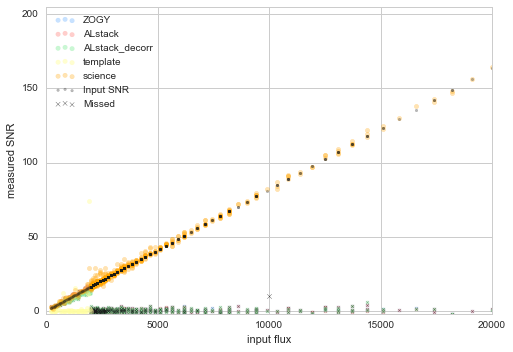

In [14]:
plotWithDetectionsHighlighted(testObj, transientsOnly=False, addPresub=True)
plt.xlim(0, 20010)
plt.ylim(-2, 205);

{'ZOGY': {'FP': 2, 'FN': 20, 'TP': 30}, 'ALstack': {'FP': 2, 'FN': 23, 'TP': 27}, 'SZOGY': {'FP': 3, 'FN': 21, 'TP': 29}, 'ALstack_decorr': {'FP': 2, 'FN': 22, 'TP': 28}}


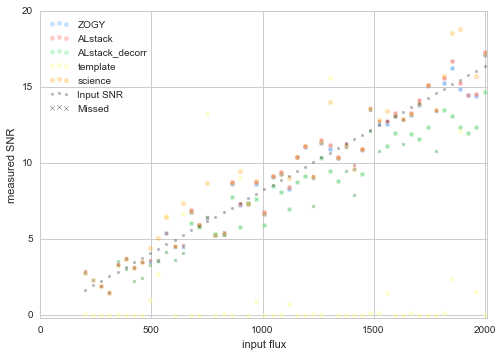

In [16]:
#%matplotlib notebook
df = plotWithDetectionsHighlighted(testObj, transientsOnly=True, addPresub=True)
plt.xlim(0, 2010)
plt.ylim(-0.2, 20);

Take a look at the apparently "anomalous" points... Well, using a radius of 15 got rid of all anomalous points! The below is what we would do if we used an exclusion radius of 5 instead...

In [17]:
tmp = df.ix[(df.scienceSNR > 12) & (df.scienceSNR < 15) & (df.inputFlux < 1500)]
dit.sizeme(tmp)

,inputFlux,templateFlux,scienceFlux,inputId,inputCentroid_x,inputCentroid_y,ZOGY_SNR,ZOGY_detected,ALstack_SNR,ALstack_detected,ALstack_decorr_SNR,ALstack_decorr_detected,templateSNR,scienceSNR,inputSNR
7,1485.714286,0.920029,1652.314241,8,346.777193,158.512358,13.447223,False,13.607483,False,12.105817,False,0.118561,13.542906,12.160626
13,1302.040816,130.578272,1708.020121,14,158.643498,144.278055,10.914438,True,11.182847,True,9.464410,True,15.591701,13.970065,10.657252


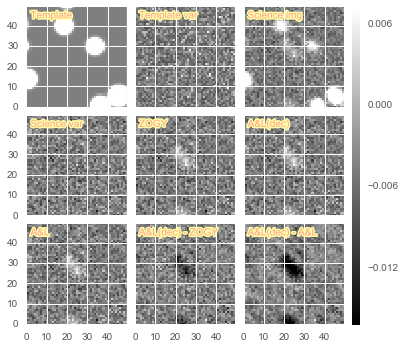

In [18]:
testObj.doPlot(centroidCoord=[tmp.inputCentroid_y.values[0], tmp.inputCentroid_x.values[0]]);

Re-do with new `avoidAllOverlaps` option set to an avoidance radius of 15. (That's big!)

In [19]:
## Just re-create the testObj here:
reload(dit)
testObj = dit.DiffimTest(n_sources=500, sourceFluxRange=(2000, 20000), 
                         varFlux2=np.linspace(200, 2000, 50),
                         #varFlux2=np.repeat(500., 50),
                         templateNoNoise=True, skyLimited=True,
                         avoidAllOverlaps=15.)

{'ZOGY': {'FP': 3, 'FN': 11, 'TP': 39}, 'ALstack': {'FP': 1, 'FN': 12, 'TP': 38}, 'SZOGY': {'FP': 1, 'FN': 10, 'TP': 40}, 'ALstack_decorr': {'FP': 1, 'FN': 12, 'TP': 38}}


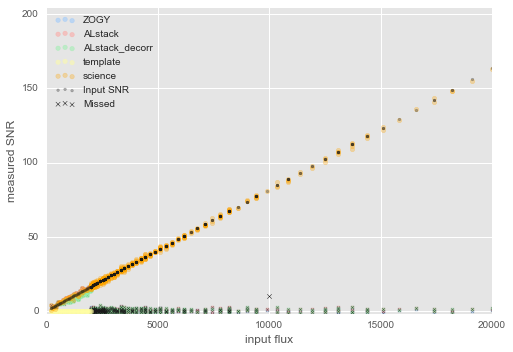

In [20]:
plotWithDetectionsHighlighted(testObj, transientsOnly=False, addPresub=True)
plt.xlim(0, 20010)
plt.ylim(-2, 205);

{'ZOGY': {'FP': 3, 'FN': 11, 'TP': 39}, 'ALstack': {'FP': 1, 'FN': 12, 'TP': 38}, 'SZOGY': {'FP': 1, 'FN': 10, 'TP': 40}, 'ALstack_decorr': {'FP': 1, 'FN': 12, 'TP': 38}}


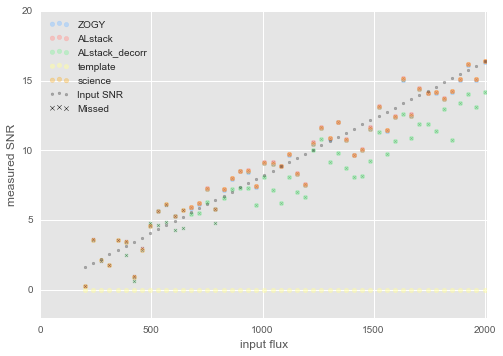

In [22]:
#%matplotlib notebook
df = plotWithDetectionsHighlighted(testObj, transientsOnly=True, addPresub=True)
plt.xlim(0, 2010)
plt.ylim(-2, 20);

Looks like `avoidAllOverlaps = 15` removes all anomalies. Yay!

Where are the ZOGY points? Are they there? I think they're all on top of the A&L points.

In [23]:
dit.sizeme(df.head())

,inputFlux,templateFlux,scienceFlux,inputId,inputCentroid_x,inputCentroid_y,ZOGY_SNR,ZOGY_detected,ALstack_SNR,ALstack_detected,ALstack_decorr_SNR,ALstack_decorr_detected,templateSNR,scienceSNR,inputSNR
0,1191.836735,1.016377e-07,907.030596,1,197.457149,414.015301,7.496908,True,7.593333,True,6.664312,True,1.390984e-08,7.512848,9.755173
1,1412.244898,5.712449e-06,1170.138568,2,152.201064,152.325854,9.633974,True,9.685084,True,8.061821,True,7.282887e-07,9.660393,11.559212
2,567.346939,8.013456e-09,752.702171,3,439.876934,358.486998,6.114537,False,6.132447,False,4.879352,False,9.749573e-10,6.130413,4.643730
3,1595.918367,1.664746e-05,1515.364168,4,371.625483,217.622330,12.378992,True,12.490211,True,10.678451,True,1.985758e-06,12.414184,13.062578
4,1338.775510,5.619036e-13,1477.943737,5,343.639653,133.832701,12.003994,True,12.021300,True,9.790266,True,8.937701e-14,12.021747,10.957866


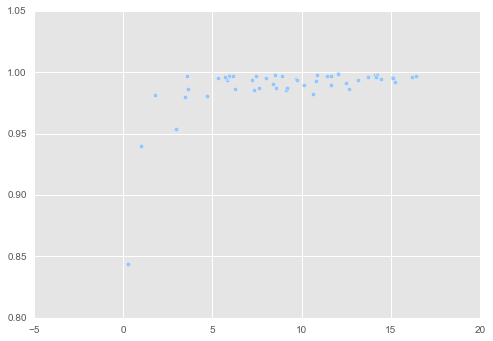

In [24]:
plt.scatter(df.ALstack_SNR, df.ZOGY_SNR / df.ALstack_SNR)

{'ZOGY': {'FP': 3, 'FN': 11, 'TP': 39}, 'ALstack': {'FP': 1, 'FN': 12, 'TP': 38}, 'SZOGY': {'FP': 1, 'FN': 10, 'TP': 40}, 'ALstack_decorr': {'FP': 1, 'FN': 12, 'TP': 38}}


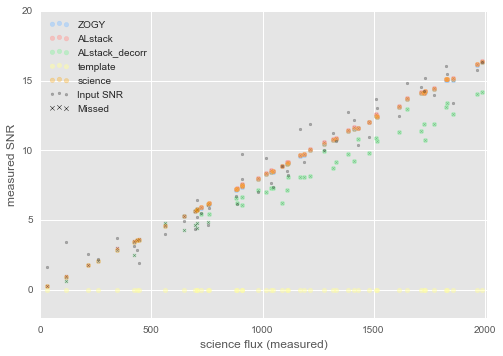

In [26]:
#%matplotlib notebook
plotWithDetectionsHighlighted(testObj, transientsOnly=True, addPresub=True,
                              xaxisIsScienceForcedPhot=True)
plt.xlim(0, 2010)
plt.ylim(-2, 20);

Re-do with all ~5-sigma sources, and no static sources. Just for fun.

Actually, this would compltely *foobar* the AL results, so add a few static sources.
Looks like A&L fails often with `n_sources` below around 100.

That would be transient fluxes of ~650 if `templateNoNoise=True` or ~750 if it's `False`.

In [27]:
reload(dit)
testObj2 = dit.DiffimTest(n_sources=91, sourceFluxRange=(2000, 20000), 
                         varFlux2=np.repeat(650., 50),
                         templateNoNoise=True, skyLimited=True,
                         avoidAllOverlaps=15.)

{'ZOGY': {'FP': 5, 'FN': 14, 'TP': 36}, 'ALstack': {'FP': 4, 'FN': 26, 'TP': 24}, 'SZOGY': {'FP': 12, 'FN': 21, 'TP': 29}, 'ALstack_decorr': {'FP': 5, 'FN': 23, 'TP': 27}}


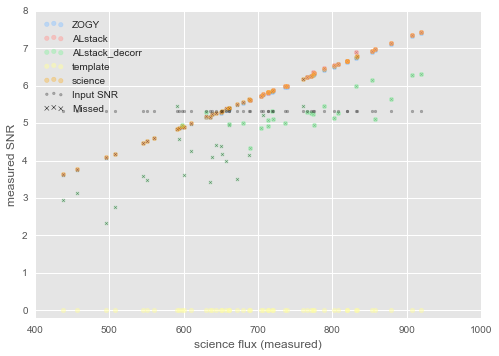

In [29]:
plotWithDetectionsHighlighted(testObj2, transientsOnly=True, addPresub=True,
                              xaxisIsScienceForcedPhot=True)
plt.xlim(400, 1000)
plt.ylim(-0.2, 8);

In [30]:
print testObj2.im1.sig, testObj2.im2.sig
print dit.computeClippedImageStats(testObj2.im1.var)
print dit.computeClippedImageStats(testObj2.im1.im)

1.4065451447 17.3171457546
(1.9783692440922556, 1.3730849706940382, 0.0, 11.0)
(0.75434670429246653, 12.827416416931918, 0.0, 1118.3127439668638)


Try it with `templateNoNoise=False` to see if `ALstack_decorr` works correctly in this case.

In [31]:
reload(dit)
testObj3 = dit.DiffimTest(n_sources=500, sourceFluxRange=(2000, 20000), 
                         varFlux2=np.linspace(200, 1000, 50),
                         templateNoNoise=False, skyLimited=False,
                         avoidAllOverlaps=15.)

{'ZOGY': {'FP': 3, 'FN': 38, 'TP': 12}, 'ALstack': {'FP': 1, 'FN': 42, 'TP': 8}, 'SZOGY': {'FP': 5, 'FN': 39, 'TP': 11}, 'ALstack_decorr': {'FP': 4, 'FN': 38, 'TP': 12}}


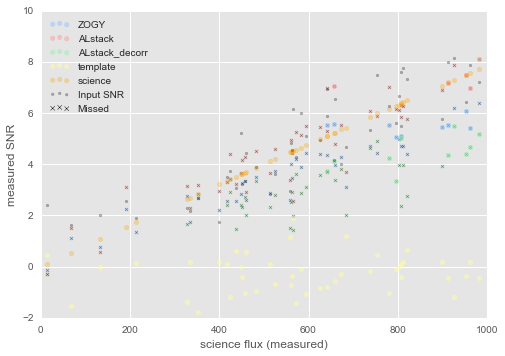

In [33]:
plotWithDetectionsHighlighted(testObj3, transientsOnly=True, addPresub=True,
                                  xaxisIsScienceForcedPhot=True)
plt.xlim(0, 1000)
plt.ylim(-2, 10);

### To be figured out: looks like `ALstack_decorr` diffim's have underestimated SNRs both when the template noise is nil, and when it is not!

This might simply be due to some rescaling that I am forcing on the decorrelated image.

First, let's look at sources that are detected in `ZOGY` but missed in `ALstack`.

{'ZOGY': {'FP': 6, 'FN': 31, 'TP': 19}, 'ALstack': {'FP': 4, 'FN': 35, 'TP': 15}, 'SZOGY': {'FP': 8, 'FN': 32, 'TP': 18}, 'ALstack_decorr': {'FP': 5, 'FN': 31, 'TP': 19}}


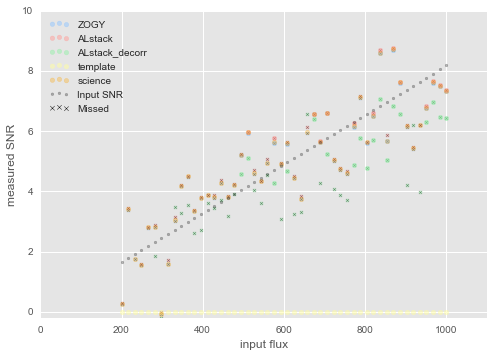

In [36]:
## Just re-create the testObj here:
reload(dit)
testObj = dit.DiffimTest(n_sources=500, sourceFluxRange=(2000, 20000), 
                         varFlux2=np.linspace(200, 1000, 50),
                         #varFlux2=np.repeat(1000., 50),
                         templateNoNoise=True, skyLimited=True,
                         avoidAllOverlaps=15.)

df = plotWithDetectionsHighlighted(testObj, transientsOnly=True, 
                                   #xaxisIsScienceForcedPhot=True,
                                   addPresub=True)
plt.xlim(0, 1100)
plt.ylim(-0.2, 10);

In [37]:
dit.sizeme(df.head())

,inputFlux,templateFlux,scienceFlux,inputId,inputCentroid_x,inputCentroid_y,ZOGY_SNR,ZOGY_detected,ALstack_SNR,ALstack_detected,ALstack_decorr_SNR,ALstack_decorr_detected,templateSNR,scienceSNR,inputSNR
0,640.816327,1.016377e-07,452.973183,1,197.457149,414.015301,3.743842,False,3.850600,False,3.324658,False,1.390984e-08,3.751934,5.245076
1,738.775510,5.712449e-06,572.984781,2,152.201064,152.325854,4.717468,False,4.763790,False,3.887871,False,7.282887e-07,4.730430,6.046871
2,363.265306,8.013456e-09,552.486195,3,439.876934,358.486998,4.488044,False,4.503024,False,3.549893,False,9.749573e-10,4.499746,2.973323
3,820.408163,1.664746e-05,794.871117,4,371.625483,217.622330,6.493475,True,6.608985,True,5.700528,True,1.985758e-06,6.511752,6.715034
4,706.122449,5.619036e-13,811.885080,5,343.639653,133.832701,6.594226,True,6.604733,True,5.227616,True,8.937701e-14,6.603957,5.779606


In [38]:
tmp = df.ix[(df.ZOGY_detected == True) & (df.ALstack_detected == False)]
dit.sizeme(tmp)

,inputFlux,templateFlux,scienceFlux,inputId,inputCentroid_x,inputCentroid_y,ZOGY_SNR,ZOGY_detected,ALstack_SNR,ALstack_detected,ALstack_decorr_SNR,ALstack_decorr_detected,templateSNR,scienceSNR,inputSNR
8,804.081633,9.715415e-08,683.410987,9,171.397858,345.360546,5.622710,True,5.648597,False,4.781408,True,1.166856e-08,5.637689,6.581401
10,853.061224,-8.330261e-07,688.268174,11,211.115835,144.440550,5.679354,True,5.878820,False,5.051929,True,-1.306371e-07,5.688413,6.982299
14,608.163265,7.694903e-05,684.848190,15,374.409837,380.450539,5.584067,True,5.645083,False,4.688629,True,1.037342e-05,5.596056,4.977811
16,493.877551,5.413031e-08,638.807227,17,181.166991,438.343432,5.198210,True,5.230229,False,4.581509,True,6.909015e-09,5.212085,4.042383


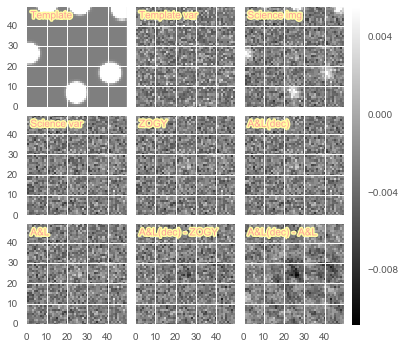

In [39]:
testObj.doPlot(centroidCoord=[tmp.inputCentroid_y.values[0], 
                              tmp.inputCentroid_x.values[0]]);

Need to fix rescaling of images for differences above -- probably related to zeroes in boundary of A&L images.